In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils import all_estimators

In [3]:
data = pd.read_csv(r"D:\BIG_DATA\charging_stations\task_2\AllCity.csv")

In [4]:
data.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
geometry,POLYGON ((494324.36910769687 4140139.900782528...,POLYGON ((494491.37794651155 4140530.022613017...,POLYGON ((494705.80941380473 4141022.185615587...,"POLYGON ((494818.1755447965 4140037.859610446,...",POLYGON ((494818.17554479634 4141263.137357092...
EV_stations_counts,0,0,0,0,0
EV_stations_geomery,[],[],[],[],[]
population,0.0,0.0,0.0,0.0,0.0
landuse,Other,Other,Other,Other,Other
nodes,0,0,0,0,0
edges,0,0,0,0,0
density,0.0,0.0,0.0,0.0,0.0
school_count,0,0,0,0,0


In [5]:
#filtering out columsn to be used for modeling
data.drop(columns=['Unnamed: 0', 'EV_stations_geomery'], inplace=True)

In [6]:
print("data size:" , data.shape)

data size: (8534, 25)


In [7]:
# Fill all NaN values with 0
data.fillna(0, inplace=True)

In [8]:
# Check for missing values in each column
missing_values = data.isna().sum()
print(missing_values)

geometry                  0
EV_stations_counts        0
population                0
landuse                   0
nodes                     0
edges                     0
density                   0
school_count              0
university_count          0
restaurant_count          0
place_of_worship_count    0
community_centre_count    0
townhall_count            0
parking_count             0
library_count             0
park_count                0
commercial_count          0
government_count          0
retail_count              0
oneway_exists             0
highway_types             0
average_lanes             0
average_maxspeed          0
city                      0
civic_count               0
dtype: int64


In [9]:
# Convert string representation of set to actual set and then to list to extract first element
def extract_first_highway(value):
    if pd.isna(value):
        return None
    try:
        # Evaluate the string as a set, convert to list and extract the first item
        evaluated_set = eval(value)
        if isinstance(evaluated_set, set) and evaluated_set:
            return list(evaluated_set)[0]
    except:
        return None

# Apply the function to the 'highway_types' column
data['high_way'] = data['highway_types'].apply(extract_first_highway)

In [10]:
# This code will display the unique values in the 'high_way' column.
unique_values_highway = data['high_way'].unique()
unique_values_highway

array([None, 'motorway', 'motorway_link', 'primary', 'secondary',
       'secondary_link', 'tertiary', 'unclassified', 'residential',
       'trunk', 'trunk_link', 'primary_link', 'tertiary_link'],
      dtype=object)

In [11]:
categorical_columns = ['geometry', 'city', 'landuse', 'oneway_exists', 'highway_types', 'high_way']
data[categorical_columns] = data[categorical_columns].astype(str)

In [12]:
data.dtypes

geometry                   object
EV_stations_counts          int64
population                float64
landuse                    object
nodes                       int64
edges                       int64
density                   float64
school_count                int64
university_count            int64
restaurant_count            int64
place_of_worship_count      int64
community_centre_count      int64
townhall_count              int64
parking_count               int64
library_count               int64
park_count                  int64
commercial_count            int64
government_count            int64
retail_count                int64
oneway_exists              object
highway_types              object
average_lanes             float64
average_maxspeed          float64
city                       object
civic_count               float64
high_way                   object
dtype: object

In [13]:
def data_splitter(data, train_cities=None, test_cities=None, test_size=0.2, random_state=23):

    if train_cities is not None:
        train = data[data['city'].isin(train_cities)]
        test = data[data['city'].isin(test_cities)]

        X_train = train.drop(['city','geometry', 'EV_stations_counts', 'highway_types'], axis=1)
        y_train = train['EV_stations_counts'].astype(int)
        y_train = y_train.apply(lambda x: 1 if x > 0 else 0)

        X_test = test.drop(['city','geometry', 'EV_stations_counts', 'highway_types'], axis=1)
        y_test = test['EV_stations_counts'].astype(int)
        y_test = y_test.apply(lambda x: 1 if x > 0 else 0)
    else:
        X = data.drop(['city','geometry', "EV_stations_counts", 'highway_types'], axis=1)
        y = data['EV_stations_counts']
        y = y.apply(lambda x: 1 if x > 0 else 0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = data_splitter(data)

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define categorical and numerical features for modelling
categorical_features = ['landuse', 'oneway_exists', 'high_way']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Creating a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the training data, and transform the test data
# Fitting the preprocessor on the training data and transforming training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [16]:
# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
print("Logistic Regression Test Accuracy: ", logreg.score(X_test_scaled, y_test))
# classification report
y_pred = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Logistic Regression Test Accuracy:  0.9619214997070885
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1638
           1       0.61      0.16      0.25        69

    accuracy                           0.96      1707
   macro avg       0.79      0.58      0.62      1707
weighted avg       0.95      0.96      0.95      1707



In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils import all_estimators
from tqdm import tqdm
import pandas as pd

def run_experiment(X_train, X_test, y_train, y_test):
    # Get all classification model classes
    classifiers = all_estimators(type_filter='classifier')

    # Initialize result table
    results = []
    models = {}
    # Run models and collect results
    for name, ClassifierClass in tqdm(classifiers):
        try:
            # Initialize model
            model = ClassifierClass()
            model.fit(X_train, y_train)
            models[name] = model
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
            auc = roc_auc_score(y_test, y_pred, multi_class='ovo')
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            
            # Append results
            results.append([name, accuracy, precision, recall, f1, auc, balanced_accuracy])
        except Exception as e:
            print(f"Error occurred for {name}: {str(e)}")

    # Create a DataFrame from results
    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC", "Balanced Accuracy"])
    results_df = results_df.sort_values(by=['F1-score', 'AUC'], ascending=False)
    return results_df, models

results_df, models = run_experiment(X_train_scaled, X_test_scaled, y_train, y_test)
print(results_df)

  0%|          | 0/43 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
 23%|██▎       | 10/43 [00:01<00:02, 13.10it/s]

Error occurred for CategoricalNB: index 7 is out of bounds for axis 1 with size 7
Error occurred for ClassifierChain: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'
Error occurred for ComplementNB: Negative values in data passed to ComplementNB (input X)


 30%|███       | 13/43 [00:01<00:04,  6.96it/s]

Error occurred for FixedThresholdClassifier: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 40%|███▉      | 17/43 [02:31<05:13, 12.06s/it]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
 42%|████▏     | 18/43 [02:35<04:19, 10.39s/it]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
 53%|█████▎    | 23/43 [02:40<01:03,  3.18s/it]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

Error occurred for MultiOutputClassifier: MultiOutputClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for MultinomialNB: Negative values in data passed to MultinomialNB (input X)
Error occurred for NuSVC: specified nu is infeasible
Error occurred for OneVsOneClassifier: OneVsOneClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for OneVsRestClassifier: OneVsRestClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for OutputCodeClassifier: OutputCodeClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([   4,    6,    9,   23,   27,   32,   33,   34,   37,   41,   46,
         50,   57,   59,   65,   77,   81,   84,   94,   99,  102,  109,
        113,  118,  119,  123,  134,  140,  143,  145,  146,  150,  155,
        159,  162,  164,  166,  167,  170,  173,  179,  18

100%|██████████| 43/43 [02:53<00:00,  4.05s/it]

Error occurred for StackingClassifier: StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
Error occurred for TunedThresholdClassifierCV: TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
Error occurred for VotingClassifier: VotingClassifier.__init__() missing 1 required positional argument: 'estimators'
                             Model  Accuracy  Precision    Recall  F1-score  \
15      LinearDiscriminantAnalysis  0.957821   0.726234  0.707318  0.716304   
8                       GaussianNB  0.896895   0.617541  0.828277  0.657635   
23   QuadraticDiscriminantAnalysis  0.900996   0.617110  0.809590  0.656670   
20                 NearestCentroid  0.874048   0.604041  0.844137  0.636430   
27                   SGDClassifier  0.951963   0.665188  0.614031  0.634120   
21     PassiveAggressiveClassifier  0.963093   0.816459  0.585125  0.628463   
17              LogisticRegression  0.961921   0.788386  0.577573  0.6

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils import all_estimators
from tqdm import tqdm
import pandas as pd

def run_experiment(X_train, X_test, y_train, y_test):
    # Get all classification model classes
    classifiers = all_estimators(type_filter='classifier')

    # Initialize result table
    results = []
    models = {}

    # Run models and collect results
    for name, ClassifierClass in tqdm(classifiers):
        try:
            # Initialize model
            model = ClassifierClass()
            model.fit(X_train, y_train)
            models[name] = model
            y_pred = model.predict(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')
            auc = roc_auc_score(y_test, y_pred)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

            # Append results
            results.append([name, accuracy, precision, recall, f1, auc, balanced_accuracy])
        except Exception as e:
            print(f"Error occurred for {name}: {str(e)}")

    # Create a DataFrame from results
    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC", "Balanced Accuracy"])
    results_df = results_df.sort_values(by=['F1-score', 'AUC'], ascending=False)
    return results_df, models

In [19]:
result_df, models = run_experiment(X_train_scaled, X_test_scaled, y_train, y_test)

  0%|          | 0/43 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
  9%|▉         | 4/43 [00:01<00:11,  3.43it/s]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 21%|██        | 9/43 [00:01<00:03,  9.18it/s]

Error occurred for CategoricalNB: index 7 is out of bounds for axis 1 with size 7
Error occurred for ClassifierChain: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'
Error occurred for ComplementNB: Negative values in data passed to ComplementNB (input X)


 26%|██▌       | 11/43 [00:02<00:07,  4.39it/s]

Error occurred for FixedThresholdClassifier: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 37%|███▋      | 16/43 [02:24<05:41, 12.64s/it]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
 42%|████▏     | 18/43 [02:27<03:42,  8.89s/it]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
 53%|█████▎    | 23/43 [02:33<01:06,  3.31s/it]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

Error occurred for MultiOutputClassifier: MultiOutputClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for MultinomialNB: Negative values in data passed to MultinomialNB (input X)
Error occurred for NuSVC: specified nu is infeasible
Error occurred for OneVsOneClassifier: OneVsOneClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for OneVsRestClassifier: OneVsRestClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for OutputCodeClassifier: OutputCodeClassifier.__init__() missing 1 required positional argument: 'estimator'
Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([   4,    6,    9,   23,   27,   32,   33,   34,   37,   41,   46,
         50,   57,   59,   65,   77,   81,   84,   94,   99,  102,  109,
        113,  118,  119,  123,  134,  140,  143,  145,  146,  150,  155,
        159,  162,  164,  166,  167,  170,  173,  179,  18

 88%|████████▊ | 38/43 [02:45<00:04,  1.16it/s]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 43/43 [02:46<00:00,  3.88s/it]

Error occurred for StackingClassifier: StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
Error occurred for TunedThresholdClassifierCV: TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
Error occurred for VotingClassifier: VotingClassifier.__init__() missing 1 required positional argument: 'estimators'


In [20]:
results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC,Balanced Accuracy
15,LinearDiscriminantAnalysis,0.957821,0.726234,0.707318,0.716304,0.707318,0.707318
8,GaussianNB,0.896895,0.617541,0.828277,0.657635,0.828277,0.828277
23,QuadraticDiscriminantAnalysis,0.900996,0.617110,0.809590,0.656670,0.809590,0.809590
20,NearestCentroid,0.874048,0.604041,0.844137,0.636430,0.844137,0.844137
27,SGDClassifier,0.951963,0.665188,0.614031,0.634120,0.614031,0.614031
21,PassiveAggressiveClassifier,0.963093,0.816459,0.585125,0.628463,0.585125,0.585125
17,LogisticRegression,0.961921,0.788386,0.577573,0.616668,0.577573,0.577573
4,DecisionTreeClassifier,0.932630,0.604494,0.631722,0.616104,0.631722,0.631722
3,CalibratedClassifierCV,0.961336,0.772294,0.577268,0.615078,0.577268,0.577268
0,AdaBoostClassifier,0.956649,0.689912,0.581767,0.611291,0.581767,0.581767


In [21]:
results_df.to_csv(r"D:\BIG_DATA\charging_stations\task_2\all_cities_random_shuffle.csv", index=False)

# Retrain the best model which is LinearDiscriminantAnalysis to save for future use

In [22]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import joblib

# Define X by dropping the target variable and other non-feature columns
X = data.drop(['city', 'geometry', 'EV_stations_counts', 'highway_types'], axis=1)

# Define Y by transforming 'EV_stations_counts' into a binary classification target
Y = data['EV_stations_counts'].apply(lambda x: 1 if x > 0 else 0)

# Create a column transformer with OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with preprocessing and Linear Discriminant Analysis as the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearDiscriminantAnalysis())
])

# Train the pipeline on the entire dataset
pipeline.fit(X, Y)

# Save the pipeline to disk
joblib.dump(pipeline, r'D:\BIG_DATA\charging_stations\task_2\lda_model.pkl')
print("Model trained on the entire dataset and saved successfully!")

Model trained on the entire dataset and saved successfully!


In [26]:
# Extract the LDA model
lda_model = pipeline.named_steps['classifier']

In [27]:
# Extract the preprocessing transformer
preprocessor = pipeline.named_steps['preprocessor']

# Get feature names from numerical and categorical transformers
numerical_features_names = numerical_features
categorical_features_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = list(numerical_features_names) + list(categorical_features_names)

In [28]:
import pandas as pd

# Get the coefficients from the LDA model
coefficients = lda_model.coef_[0]  # For binary classification, take the first row

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Display the feature importance
print(feature_importance)

                    Feature  Coefficient
1                     nodes     3.999494
33  high_way_secondary_link     1.864255
16            average_lanes     1.275105
26            high_way_None     1.067620
20       landuse_commercial     0.920481
6          restaurant_count     0.693026
38    high_way_unclassified     0.599333
25        oneway_exists_Yes     0.534535
15             retail_count     0.511838
7    place_of_worship_count     0.392839
14         government_count     0.384766
19            landuse_Other     0.348337
11            library_count     0.347701
21       landuse_industrial     0.322299
10            parking_count     0.264041
30    high_way_primary_link     0.225292
35   high_way_tertiary_link     0.215291
5          university_count     0.210958
4              school_count     0.203222
18              civic_count     0.123508
9            townhall_count     0.088515
8    community_centre_count     0.082830
27        high_way_motorway     0.031089
3               

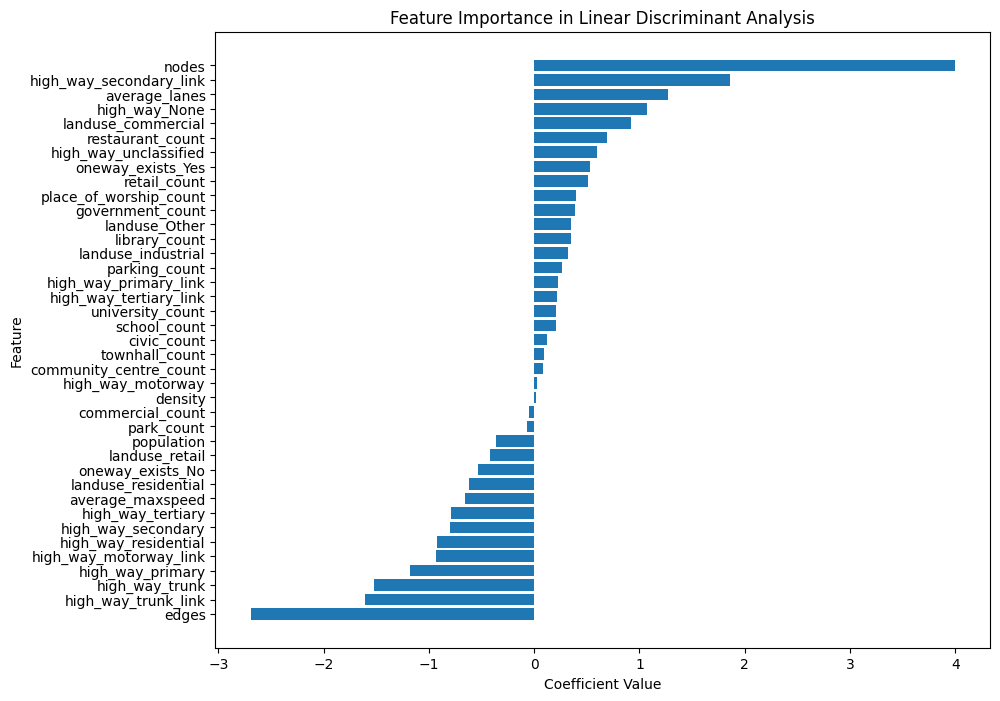

In [29]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Discriminant Analysis')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

In [23]:
#import joblib

# Load the trained model from the file
#pipeline = joblib.load('lda_model.pkl')
# Make predictions
#predictions = pipeline.predict(new_data_prepared)